# Modelling the Annual Revenue of the UBC Blue Chip Cafe

## Problem Statement

In this project, we would construct a stochastic model to analyze how daily temperature and precipitation influence the daily revenue for the UBC Blue Chip Cafe.

The Blue Cafe has access to the following data:

* Daily average temperature (in degrees Celsius) from January 1, 1997 through December 31, 2022.
* Daily precipitation (in millimeters) from January 1, 1997 through December 31, 2022.
* Total frequency of customers in the month of March 2024 for each hour of operation.

We would use the datas above to construct a stochastic models which describes how revenue change based on weather.

## Variables and Parameters

Below are the variables and parameters for this modelling project.

| Description | Symbol | Dimension | Type |
| :----: | :--: | :--: | :---: |
|the total daily customers| C | 1 | Dependent Variable |
|the average daily temperature| T | $^{\circ}$C | Independent Variable |
|the total daily precipitation| P | mm of water | Independent Variable |
|the reference number of customers| $C_{0}$ | 1 |Parameter|
|the reference daily temperature| $T_{0}$ | $^{\circ}$C|Parameter|
|the reference precipitation|$P_{0}$|mm of water|Parameter|
|Rate of change of customers with respect to temperature|a|1/$^{\circ}$C|Parameter|
|Rate of change of customers with respect to precipitation|b|1/mm of water|Parameter|
|price of one drinks| $P_{d}$| Dollars| Parameter|
|price of one cookies| $P_{c}$| Dollars| Parameter|
|cost of one drinks| $K_{d}$| Dollars| Parameter|
|cost of one cookies| $K_{c}$| Dollars| Parameter|

## Assumptions and Constraints

* The prices of items are the same from 1997 to 2022.
* Each customer only purchases 1 pastry and 1 drink.

We use the online menu of Blue Chip Cafe to get the prices of products. 
* The average price of a piece of pastry are the same and equal to 3 dollars.
* The average price of drinks equal to 5.12 dollars.
* There are no disruptions to service.
* The cost of making one cup of coffee is \\$1.84, including the cost of coffee, milk, water, work of an employee, electricity, and rentals. The price for cookies is \\$1.896 (Arias, 2024).
* The business always has more cookies and drinks available to sell.
* Opening hours are the same for the entire period.
* Only weather (temperature and precipitation) influences the amount of customers served.

## Building Solutions

After analyzing the data, the owner of UBC Blue Chip have determined that the number of customers has the form
$$C(T,P) = \max \{c(T,P),0 \}$$ 

$$c(T,P) = C_0 +a(T −T_0)−b(P −P_0)$$

Where 

* the total daily customers is $C$
* the average daily temperature is $T$
* the total daily precipitation is $P$
* the reference number of customers is $C_{0}$
* the reference temperature is $T_{0}$
* the reference precipitation is $P_{0}$
* the rate of change of customers with respect to temperature is $a$
* the rate of change of customers with respect to precipitation is $b$

In [2]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
%matplotlib inline

In [3]:
customer = pd.read_csv('customer.csv')
weather = pd.read_csv('vancouver_weather.csv')

T = weather['avg_temperature']
P = weather['precipitation']

### Finding $P_{0}$ and $T_{0}$

Since mean is a representative measure of the data and centers the models around the most common weather conditions, we will set $P_{0}$ the reference precipitation to the mean average precipitation from 1997 to 2022. $T_{0}$, the reference temperature, will equal to the mean average tmperature from 1997 to 2022.

In [4]:
T0 = np.mean(T)
P0 = np.mean(P)

In [10]:
print("TO = ", T0)
print("PO = ", P0)

TO =  10.582639005897219
PO =  3.2037068239258635


Next, we will use the kernel density function to create a PDF for the temperature and precipication datas.

### PDF of Temperatures

In [44]:
pdf_temp = stats.gaussian_kde(T)

In [29]:
x = np.linspace(-15,30,1000)

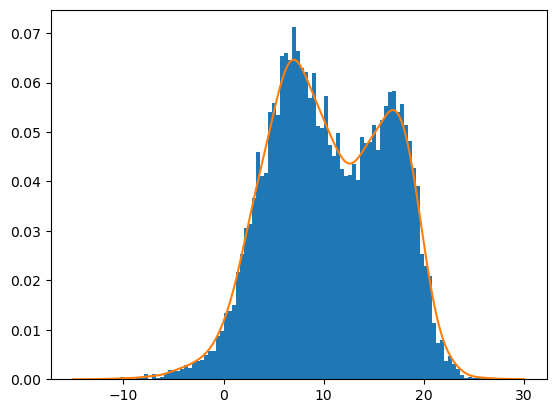

In [30]:
plt.hist(T, bins=100, density = True)
plt.plot(x,pdf_temp(x))
plt.show()

### PDF of Precipications

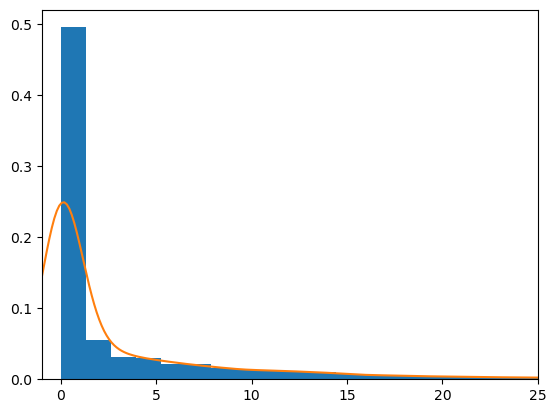

In [65]:
pdf_prep = stats.gaussian_kde(P)
x2 = np.linspace(-1,25,200)
plt.hist(P, bins=70, density = True)
plt.plot(x2,pdf_prep(x2))
plt.xlim([-1,25])
plt.show()

### Finding $C_{0}$

To calculate $C_0$, we will sum the customer numbers in the month of March and divide by 31 to obtain the daily reference customer count.

In [28]:
C0 = np.sum(customer['Monthly_Frequency_Customers'])/31 # Daily average
print("CO = ", C0)

CO =  185.2258064516129


### Determining a and b

- We can find $a$ using $\Delta C / \Delta T$. Given the customer count data for March 2024, we assume a 20% quantile for March and build a normal distribution based on this assumption. We consider a normal distribution appropriate because customer counts generally increase with temperature, peaking around June and July and decreasing in January and December, as shown in the graph above. Next, we calculate the difference between the tail and head values, denoted as $\Delta C$. Then, we group the weather data by year and month to obtain the monthly temperature difference, which we multiply by 12 to estimate the yearly temperature change, $\Delta T$.
- We find $b$ in a similar way for $\Delta C / \Delta P$.

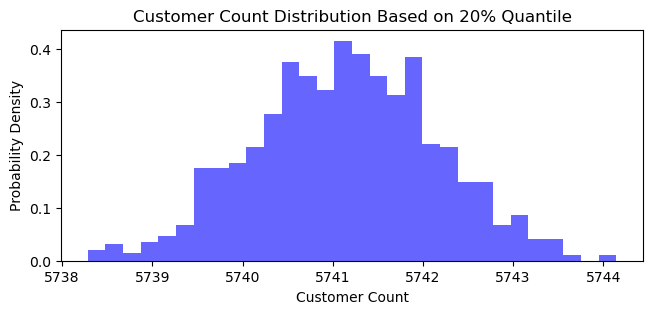

In [29]:
# Given customer count in March
customers_march = C0*31

# Assuming 5742.0 is the 20th percentile in a normal distribution
quantile = 0.20

# Calculate the mean and standard deviation for the distribution
# We assume a standard normal distribution, then solve for the parameters
mean, std_dev = stats.norm.ppf(quantile, loc=customers_march, scale=1), 1  # start with std deviation as 1

# Adjust to reflect the assumption based on 20th quantile
std_dev = (mean - customers_march) / stats.norm.ppf(quantile)

# Generate a normal distribution based on these parameters
distribution = np.random.normal(loc=mean, scale=std_dev, size=1000)

plt.figure(figsize=(7.5, 3))
plt.hist(distribution, bins=30, density=True, alpha=0.6, color='b')
plt.title("Customer Count Distribution Based on 20% Quantile")
plt.xlabel("Customer Count"); plt.ylabel("Probability Density")
plt.show()

We found $a$ and $b$ to be approximately $2.9$ and $0.99$, respectively. We now use the customer data (total monthly customers and daily average) to compare the $a$ and $b$ parameters. We take weather data from March of 2022, as it is the most recent available.

In [30]:
# Select data for period
March_22 = weather[weather['year'] == 2022]
March_22 = March_22[March_22['month'] == 3]
T_22_03 = March_22['avg_temperature']; P_22_03 = March_22['precipitation']
C_March_24 = customer['Monthly_Frequency_Customers']
T_22_03 = np.array(T_22_03.tolist()); P_22_03 = np.array(P_22_03.tolist())
C_March_24 = np.array(C_March_24.tolist())

In [31]:
a = 2.9; b = 0.99 # Estimates for parameters

# Make simulation
Customers_tune = Customers_in_period(T_22_03,P_22_03)
Month_customs_22_03 = np.round(np.sum(Customers_tune))
Day_avg_22_03 = np.mean(Customers_tune)
print('Estimates: ', Month_customs_22_03, ',', Day_avg_22_03)
print('Actual values: ',np.sum(C_March_24),',',np.sum(C_March_24)/31)

Estimates:  5991.0 , 193.26674222762722
Actual values:  5742 , 185.2258064516129


### Revenue Function

In [32]:
## Customers function
c = lambda t,p: C0 + a*(T0 - t) - b*(p - P0)

def Customers_in_period(temp,pre):
    customs = []
    for k in range(len(temp)):
        DayCustomer = max(c(temp[k],pre[k]),0)
        customs.append(DayCustomer)
    return customs

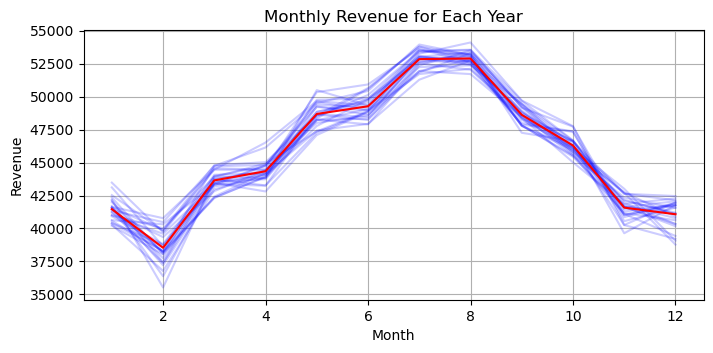

In [20]:
def period_revenue(data):
    T = data['avg_temperature']
    P = data['precipitation']
    c = C0 + a*(T - T0) - b * (P - P0)
    c = np.maximum(c,0)
    rev = np.sum(c) * 8.12
    return rev

monthly_revenue = {} # Calculate revenue per month
for year in range(1997, 2023):
    yearly_data = weather[weather['year'] == year]
    monthly_data = yearly_data.groupby('month')
    monthly_revenue[year] = {month: period_revenue(month_data) for month, month_data in monthly_data}

# Convert monthly revenue to DataFrame for easier plotting
monly_rev_df = pd.DataFrame(monthly_revenue).T

plt.figure(figsize=(8, 3.5)) # Plot revenue for each year
for year in monly_rev_df.index:
    plt.plot(monly_rev_df.columns,monly_rev_df.loc[year],color='blue',alpha=0.2)

## monthly_average
monthly_avg = [np.mean(monly_rev_df[month]) for month in monly_rev_df.columns]
monly_rev_df.loc['Month_Average'] = monthly_avg
plt.plot(monly_rev_df.columns, monly_rev_df.loc['Month_Average'], color = 'red')

plt.xlabel('Month'); plt.ylabel('Revenue'); plt.grid()
plt.title('Monthly Revenue for Each Year')
plt.show()

In [21]:
## Calculate for annual revenue
monly_rev_df['annual'] = pd.DataFrame.sum(monly_rev_df,axis=1)
Ann_rev = monly_rev_df['annual']
Ann_rev = Ann_rev.tolist()
Anual_avg = Ann_rev[-1]
Annual_min = np.min(Ann_rev); Annual_max = np.max(Ann_rev)
print(Anual_avg, Annual_min, Annual_max)

549319.3298263026 544184.8399147275 557449.4755982199


### Income Function

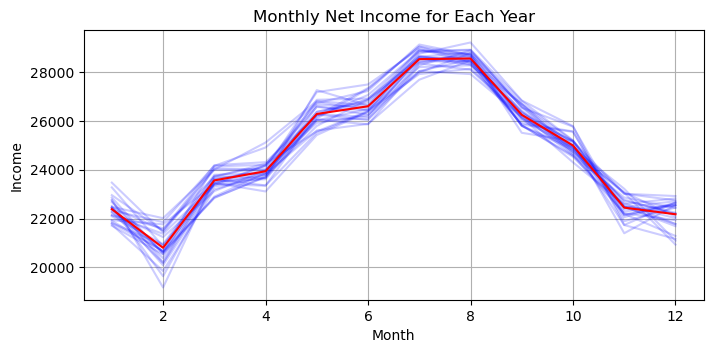

In [22]:
def period_income(data):
    T = data['avg_temperature']
    P = data['precipitation']
    c = C0 + a*(T - T0) - b * (P - P0)
    c = np.maximum(c,0)
    rev = np.sum(c) * 8.12
    income = rev - np.sum(c) * (1.84 + 1.896)
    return income

monthly_income = {} # Calculate revenue per month
for year in range(1997, 2023):
    yearly_data = weather[weather['year'] == year]
    monthly_data = yearly_data.groupby('month')
    monthly_income[year] = {month: period_income(month_data) for month, month_data in monthly_data}

# Convert monthly revenue to DataFrame for easier plotting
monly_rev_df = pd.DataFrame(monthly_income).T

plt.figure(figsize=(8, 3.5)) # Plot revenue for each year
for year in monly_rev_df.index:
    plt.plot(monly_rev_df.columns,monly_rev_df.loc[year],color='blue',alpha=0.2)

## monthly_average
monthly_avg = [np.mean(monly_rev_df[month]) for month in monly_rev_df.columns]
monly_rev_df.loc['Month_Average'] = monthly_avg
plt.plot(monly_rev_df.columns, monly_rev_df.loc['Month_Average'], color = 'red')

plt.xlabel('Month'); plt.ylabel('Income'); plt.grid()
plt.title('Monthly Net Income for Each Year')
plt.show()

In [23]:
## Calculate annual profits
monly_rev_df['annual'] = pd.DataFrame.sum(monly_rev_df,axis=1)
Ann_rev = monly_rev_df['annual']
Ann_rev = Ann_rev.tolist()
Anual_avg = Ann_rev[-1]
Annual_min = np.min(Ann_rev); Annual_max = np.max(Ann_rev)
print(Anual_avg, Annual_min, Annual_max)

296578.31797518604 293806.1992840105 300967.79569243797


## Analyze and Assess

### Monthly Net Income and Revenue Analysis

The average monthly net income starts out at around 32,000 dollars per month in Janurary and reaches the lowest point in Feburary at around 30,000 dollars. Feburary's net income also has more variance in revenue than revenues on other months. The net income steadily increases from the month of Febuary to August. The net income at the month of July and August is the highest point at around $41,000. Then, the income decreases overtime from the month of August to December. The value of the income in the month of December is similar to the monthly income on Janurary.

One reason the net revenue on December, Janurary, Feburary are low could be due to colder weather and snow, which deters students from going to Blue Chip to buy coffee. While the month of June, July, and August, are summer time so more students would go out and buy coffee from Bluechip. The monthly revenue follows a very similar trend with the monthly net income except with higher value. This is because monthly net income is the monthly revenue prior to subtracting the operation costs. We are assuming the operation costs are constant throughout the month.

Janurary, Feburary, and December are times when the business is the least profitable while the Month of July and August is when our business is the most profitable. We could consider decreasing the price of our items on Feburary to attract more customers and increasing the price of the items on July and August to maximize profit. In addition, we could shift the price of our items up in other months where the business is profitable and decreases the price of item on months where they aren't that profitable.

For the annual revenue, the average annual revenue is 549,319.3 dollars. The maximum annual revenue is 544,184.8 dollars. The minimum annual revenue is 557,449.5 dollars. The annual profit is the annual revenue minus the operation cost. For the annual profit, the average annual profit is is 296,578 dollars. The maximum annual profit is 300,967 dollars. The minimum annual profit 293,806
dollars.

## Conclusions
- More advanced models could include the customer choice for what and how many products to purchase, the associated costs for the cafe for each item sold (ingredients, paper cups, etc.), or varying prices for the menu items throughout time.
- For an advanced model, we could consider a more realistic menu and adding uncertainty to price of goods to show a range of the expense each customer spents at the coffee.

## References

1. UBC Food services. *Blue Chip Cookies*. UBC Student Housing and Community Services. https://food.ubc.ca/places/blue-chip-cafe/

2. Contributor, & By. (1970, November 30). *How much does your coffee cost?*. Coffee Ti Magazine. http://www.coffeeteaimagazine.com/how-much-does-your-coffee-cost/#:~:text=To%20prepare%20one%20cup%20of,rise%20up%20to%2050%20cents.

3. Arias, T. (2024, October 14). *Cheap vs. expensive ingredients in chocolate chip cookies*. Handle the Heat. https://handletheheat.com/cheap-vs-expensive-cookies/

.